In [ ]:
from cryosparc.tools import CryoSPARC
import json
import numpy as np
import pandas as pd
import plotnine
from plotnine import ggplot, aes

with open('/u/rposert/instance-info.json', 'r') as f:
    instance_info = json.load(f)

cs = CryoSPARC(**instance_info)
cs.test_connection()

# Problem
It is not rare to have a target which:
 * has some type of symmetry, and
 * at each symmetry-related copy of some position, either has or does not have a feature (say, a binding partner).

Depending on the symmetry involved, such a situation can become unwieldy. For a simple C2 symmetric protein (as will be used in this demonstration), only four classes are necessary to capture the full range of possible particle states:
 1. No binder
 2. binder on A
 3. binder on B
 4. binder on A and B

However, even with another common symmetry like, say, the C5 symmetry of Cys-loop receptors, the number of possible particle states is 2^5 = 32 --- and this is *assuming perfect classification*. As the number of states increases as 2^N, the odds of perfect classification go down as the symmetry number goes up.

# Solution
Rather than attempt to classify the entire protein at once, we can instead perform symmettry expansion and then classify the presence or absence of the feature of interest *in only one symmetry-related position*. Since the particles have been expanded, we're really detecting presence/absence in each position. Then, we can come back and count the number of positions which have our feature of interest.

In higher symmetries, it may instead be useful to develop some method of describing the relationship of the regions of interest to each other. For instance, in a C4 symmetric target, it would be useful to split the particles into those that have
 1. 0 features of interest
 2. 3 features of interest
 3. 4 features of interest
 4. 2 features of interest on adjacent subunits
 5. 2 features of interest on opposite subunits

# Implementation
After symmetry expanding and performing 3D classification, we can count the number of expanded subunits that contain a feature of interest.
Then, using the source id, we can figure out how many of that feature the original particle had. We can then partition particles
into subsets based on their composition with potentially more sensitivity than other methods which consider each symmetry-related position as
distinct.

# Example dataset
Here we will be classifying particles from [EMPIAR-10425](https://www.ebi.ac.uk/empiar/EMPIAR-10425/). Specifically, we are trying to split particles into sets which have 0, 1, or 2 copies of the MlaB subunit, like so:

![Maps showing subunits with 0, 1, and 2 MlaB subunits](attachments/sym-exp-filter_mla-count.png).

We accomplish this by
 1. Symmetry-expanding the particles in C2
 2. Create a mask around a single MlaB binding site
 3. Performing a 3D classification using that mask
 4. For each particle image, count how many times it has or does not have MlaB
 5. Export the particles in their appropriate sets

![The proposed workflow](attachments/sym-exp-filter_workflow.png)

# Counting the subunits
Here, we are trying to find particles which have 0, 1, or 2 MlaB. The relevant job numbers are:
* J12 - Non-Uniform Refinement with enforced C2 symmetry
* J14 - Symmetry Expansion in C2 (rotate all potential MlaB binding sites into same position in space)
* J17 - 3D Classification with a mask surrounding **only one** MlaB binding site. It's important to note that the out-of-mask position is *not informative* in this job.
    * Class 0 here has no MlaB in mask
    * Class 1 and 2 both have an MlaB mask

In [14]:
project_number = 'P310'
class_job_number = 'J17'

project = cs.find_project(project_number)
class_job = project.find_job(class_job_number)
class_zero = class_job.load_output('particles_class_0')
class_one = class_job.load_output('particles_class_1')
class_two = class_job.load_output('particles_class_2')

First, we create pandas data frames to make life easier. We combine the two classes which had MlaB.

In [25]:
df_zero = pd.DataFrame(class_zero.rows())
df_one = pd.DataFrame(class_one.rows())
df_two = pd.DataFrame(class_two.rows())
df_with_mlab = pd.concat([df_one, df_two])

Next, we count the number of times a given particle had or did not have MlaB. We use `sym_expand/src_uid` here since that is unique to the original particle, not the symmetry-expanded particles we're working with.

In [34]:
no_counts = df_zero['sym_expand/src_uid'].value_counts()
yes_counts = df_with_mlab['sym_expand/src_uid'].value_counts()

# get yes and no counts in the same df
count_by_src_uid = no_counts.to_frame().join(
    yes_counts,
    how = 'outer',
    lsuffix = '_no',
    rsuffix = '_yes'
).fillna(0)

Now we make sure that each original (un-expanded) particle appears exactly twice in our total counts.

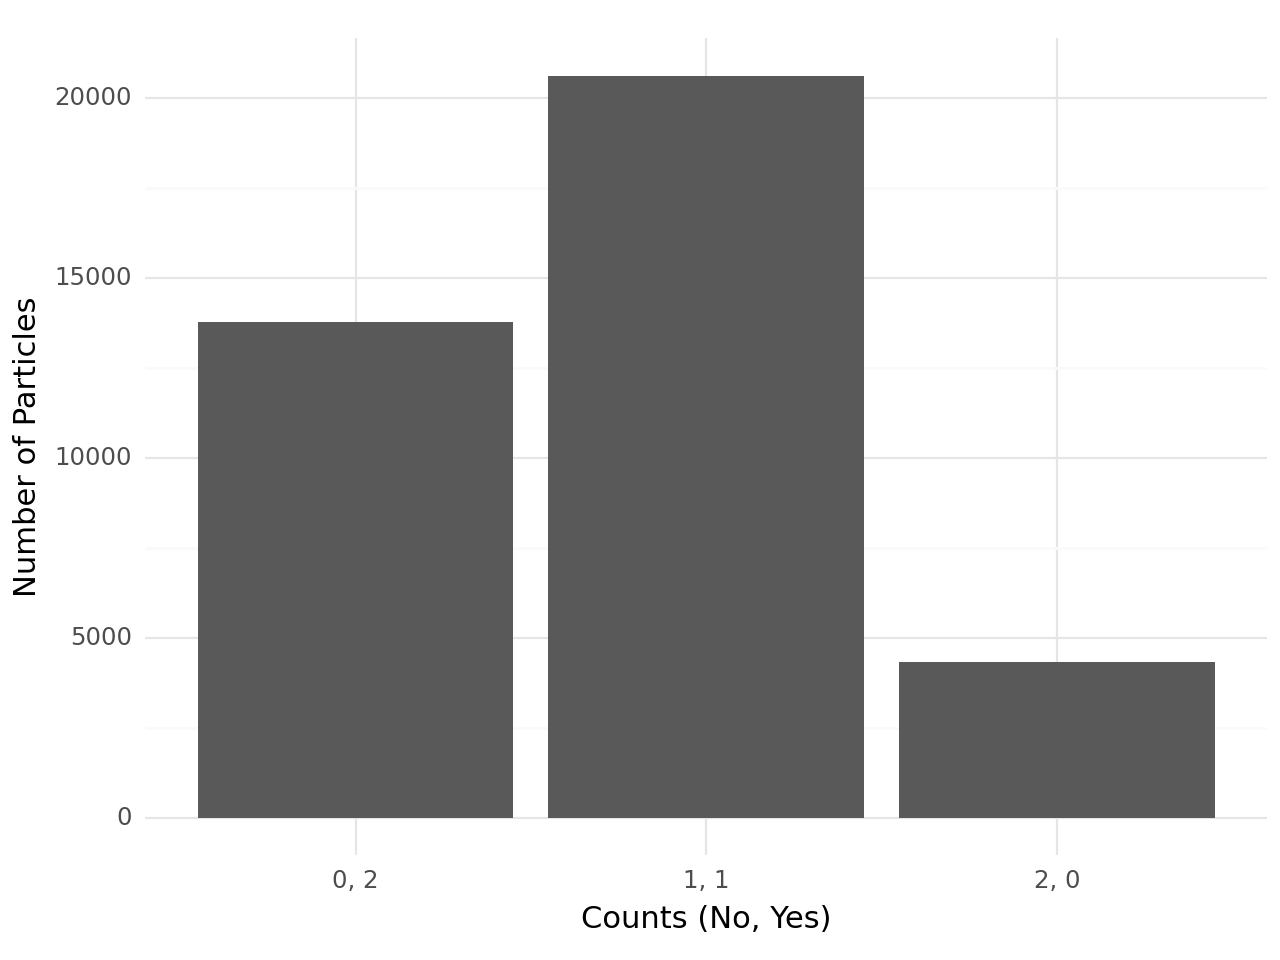

<Figure Size: (640 x 480)>

In [48]:
# sanity check - things should only end up at (2,0), (1,1), or (0,2)
count_by_src_uid['coordinate'] = count_by_src_uid['count_no'].astype(int).astype(str) + ', ' + count_by_src_uid['count_yes'].astype(int).astype(str)
(
ggplot(count_by_src_uid, aes('coordinate'))
+ plotnine.theme_minimal()
+ plotnine.geom_bar()
+ plotnine.labs(
    x = 'Counts (No, Yes)',
    y = 'Number of Particles'
)
)

We've successfully split particles into whether they seem to have zero, one, or two MlaB components. It seems that it is rare to have *no* MlaB!

# Export

To return these particle sets to CryoSPARC, we just need to create an external job for each subset.

In [62]:
double_mlab_uids = count_by_src_uid.loc[count_by_src_uid['coordinate'] == '0, 2'].reset_index()['sym_expand/src_uid']
single_mlab_uids = count_by_src_uid.loc[count_by_src_uid['coordinate'] == '1, 1'].reset_index()['sym_expand/src_uid']
zero_mlab_uids = count_by_src_uid.loc[count_by_src_uid['coordinate'] == '2, 0'].reset_index()['sym_expand/src_uid']

unexpanded_job_number = 'J12'
unexpanded_refinement = project.find_job(unexpanded_job_number)
unexpanded_particles = unexpanded_refinement.load_output('particles')

zero_mlab_particles = unexpanded_particles.query({
    'uid': zero_mlab_uids
})
single_mlab_particles = unexpanded_particles.query({
    'uid': single_mlab_uids
})
double_mlab_particles = unexpanded_particles.query({
    'uid': double_mlab_uids
})

desired_workspace = 'W2'
project.save_external_result(
    desired_workspace,
    zero_mlab_particles,
    type = 'particle',
    title = 'No MlaB',
    passthrough = (unexpanded_job_number, 'particles')
)
project.save_external_result(
    desired_workspace,
    single_mlab_particles,
    type = 'particle',
    title = 'One MlaB',
    passthrough = (unexpanded_job_number, 'particles')
)
project.save_external_result(
    desired_workspace,
    double_mlab_particles,
    type = 'particle',
    title = 'Two MlaB',
    passthrough = (unexpanded_job_number, 'particles')
)

'J25'

The particles are now ready for further refinement or classification!